# Image Classification and Segmentation using ArcGIS API for Python

## Introduction

Segmentation and classification are very important topics in GIS/remote sensing. Both them are approaches to extracting features from imagery based on objects. Segmentation groups pixels in close proximity and having similar spectral characteristics into a segment, which doesn't need any training data and is considered as **unsupervised learning**. In contrast, image classification is a type of **supervised learning** which classifies each pixel to a class in the training data. In this guide, we are going to demonstrate both techniques using ArcGIS API for Python.

In [77]:
from arcgis import GIS
from arcgis.features import FeatureSet, FeatureCollection

In [87]:
gis = GIS("https://pythonapi.playground.esri.com/portal", 'portaladmin', 'esri.agp8')
# gis = GIS("https://dev0003747.esri.com/portal", "admin", "admin123")

# Classification

In this example, we are going to perfrom a land cover classification using a Landsat image in Iowa and hand labelled training data. There are four classes in total: Developed Area, Forest, Planted/Cultivated, and Water.

As the first step, we are going to load the training data we have created using Training Samples Manager ArcGIS Pro.

<Item title:"training_samples" type:Feature Layer Collection owner:api_data_owner>
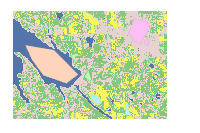

In [88]:
items1 = gis.content.search("training_samples", item_type="Feature Layer")
items1[0]

In [113]:
map1 = gis.map('Iowa')
map1

MapView(layout=Layout(height='400px', width='100%'))

In [90]:
map1.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'xmin': -10357358.3716515,
 'ymin': 5063187.75726388,
 'xmax': -10340267.8481094,
 'ymax': 5075204.7581259}

map1.add_layer(items1[0])
map1.lengend = True

In [91]:
query_result = items1[0].layers[0].query()
training_sample_json = query_result.to_json

<Item title:"Multispectral Landsat" type:Imagery Layer owner:esri_livingatlas>
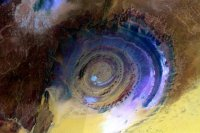

In [92]:
# items2 = gis.content.search("title: landsat_Iowa", item_type="Imagery Layer", outside_org=True)
items2 = gis.content.search("title: multispectral landsat", item_type="Imagery Layer", outside_org=True)
items2[0]

In [93]:
landsat_layer = items2[0].layers[0]
map1.add_layer(landsat_layer)
map1.add_layer(items1[0])

In [95]:
from arcgis.raster.analytics import train_classifier

classifier_definition = train_classifier(input_raster=landsat_layer, 
                                         input_training_sample_json=training_sample_json, 
                                         classifier_parameters={"method":"svm", 
                                                                "params":{"maxSampleClass":500}},
                                         gis=gis)

In [106]:
import pandas as pd

pd.DataFrame(landsat_layer.key_properties()['BandProperties'])

,BandName,WavelengthMax,WavelengthMin
0,CoastalAerosol,450.0,430.0
1,Blue,510.0,450.0
2,Green,590.0,530.0
3,Red,670.0,640.0
4,NearInfrared,880.0,850.0
5,ShortWaveInfrared_1,1650.0,1570.0
6,ShortWaveInfrared_2,2290.0,2110.0
7,Cirrus,1380.0,1360.0
8,NaN,NaN,NaN


In [110]:
items3 = gis.content.search("title: landsat_Iowa_9bands_updated", item_type="Imagery Layer", outside_org=True)
items3[0]

<Item title:"landsat_Iowa_9bands_updated" type:Imagery Layer owner:api_data_owner>

In [111]:
from arcgis.raster.analytics import classify

classified_output = classify(input_raster=items3[0].layers[0], 
                             input_classifier_definition=classifier_definition)
classified_output

<Item title:"Classify_8ZE4IF" type:Imagery Layer owner:portaladmin>

In [114]:
map1.add_layer(classified_output)

## Image Segmentation

The goal of image segmentation is to identify segments in your imagery by grouping adjacent pixels together that have similar spectral and spatial characteristics. `arcgis.raster.analytics.segment` uses an algorithm called Mean Shift which uses a moving window that calculates an average pixel value to determine which pixels should be included in each segment. As the window moves over the image, it iteratively recomputes the value to make sure that each segment is suitable. The result is a grouping of image pixels into a segment characterized by an average color.

In this example, we are going to using image segmentation to extract center-pivot in some chosen region in Saudi Arabia. First, let's search for a 8-bit landsat layer we've published beforehand.

In [46]:
landsat_pivot_items = gis.content.search("title: landsat_pviot_345_8bit", item_type="Imagery Layer")
landsat_pivot_items[0]

<Item title:"landsat_pviot_345_8bit" type:Imagery Layer owner:api_data_owner>

In [50]:
landsat_pivot_layer = landsat_pivot_items[0].layers[0]

The characteristics of the image segments depend on three parameters: spectral detail, spatial detail, and minimum segment size. You can vary the amount of detail that characterizes a feature of interest. For example, if you are more interested in impervious features than in individual buildings, adjust the spatial detail parameter to a small number; a lower number results in more smoothing and less detail.

- The segment function provides multi-band support. You can define which 3 bands are used in segmentation. Default is [0,1,2]. 
- `spectral_detail` parameter is used to set the level of importance given to the spectral differences of features in your imagery. Default is 15.5.
- `spatial_detail`, on the other hand, sets the level of importance given to the proximity between features in your imagery. Default is 15.

In [53]:
from arcgis.raster.analytics import segment

seg_output = segment(input_raster=landsat_pivot_layer)
seg_output

<Item title:"Segment_V2BP9O" type:Imagery Layer owner:portaladmin>


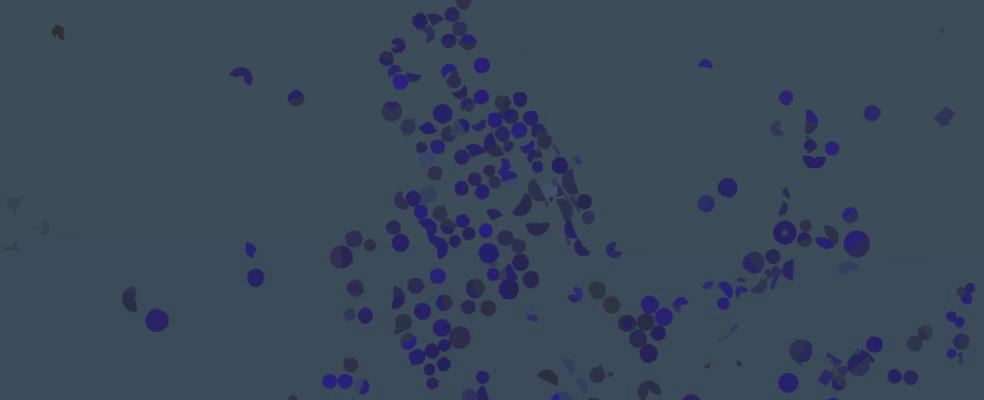

In [62]:
map2 = gis.map('Saudi Arabia')
map2

In [61]:
map2.extent = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
                                         'type': 'extent',
                                         'xmax': 4735079.27946308,
                                         'xmin': 4720420.87480519,
                                         'ymax': 3226614.75178954,
                                         'ymin': 3214862.51053094}
map2.add_layer(seg_output);